# Part 2. Preprocessing, Feature Engineering, and Outlier Cleaning

## Importing libraries and setting global variables

In [1]:
# Import usual library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing datasets

In [2]:
def read_train_test(status='train'):
    # Function to select dataset to read
    if status == 'train':
        df = pd.read_csv('../datasets/train_fill.csv')
    elif status == 'test':
        df = pd.read_csv('../datasets/test_fill.csv')
    else:
        print(f"Select the correct dataset")
    return df

In [188]:
# Select 'train' to read train.csv
# Select 'test' to read test.csv
status = 'test'
df = read_train_test(status)

### Grouping of columns

In [4]:
# create column groups to classify action
cols_to_drop = []

#### ID Group

In [5]:
df['Order'].nunique()

2197

In [6]:
df['pid'].nunique()

2197

In [7]:
# Add these two columns to drop since they're mostly unique
cols_to_drop.extend(['Order','pid'])

#### Lot Group

In [8]:
lot_cols = df.columns[df.columns.str.contains('lot')]
df[lot_cols].head(2)

,lot_frontage,lot_area,lot_shape,lot_contour,lot_config,lot_slope
0,80.0,9605,Reg,Lvl,Corner,Gtl
1,90.0,14684,IR1,Lvl,CulDSac,Gtl


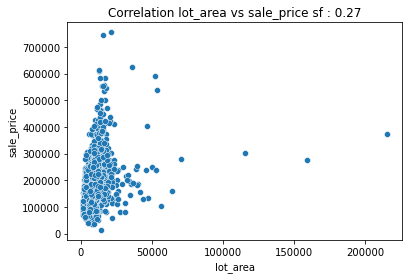

In [9]:
# check correlation of lot area and sale price

corr = df[['lot_area','sale_price']].corr()

sns.scatterplot(x='lot_area',y='sale_price',data=df)
plt.title(f"Correlation lot_area vs sale_price sf : {corr['lot_area'][1].round(2)}");

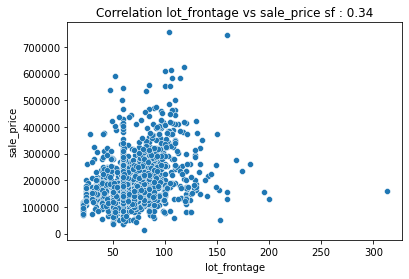

In [10]:
# check correlation of lot frontage and sale price

corr = df[['lot_frontage','sale_price']].corr()

sns.scatterplot(x='lot_frontage',y='sale_price',data=df)
plt.title(f"Correlation lot_frontage vs sale_price sf : {corr['lot_frontage'][1].round(2)}");

This column can be left as such

#### SF Group (Square Footage)

In [11]:
sf_cols = df.columns[df.columns.str.contains('sf')]
df[sf_cols].head(5)

,basement_fin_sf_1,basement_fin_sf_2,basement_unf_sf,total_basement_sf,1st_floor_sf,2nd_floor_sf,low_quality_fin_sf,ground_living_sf,wood_deck_sf,open_porch_sf
0,0.0,0.0,1218.0,1218.0,1218,0,0,1218,0,178
1,485.0,177.0,1496.0,2158.0,2196,0,0,2196,84,70
2,111.0,354.0,354.0,819.0,1344,0,0,1344,0,118
3,0.0,0.0,1451.0,1451.0,1456,0,0,1456,192,42
4,241.0,113.0,30.0,384.0,744,630,0,1374,0,0


In [12]:
# check for redundant columns
pd.Series(df['ground_living_sf'] == \
          (df['1st_floor_sf']+df['2nd_floor_sf'])).mean(0).round(2)

# 0.98 majority of ground_living_sf is a summation of 1st_floor_sf and 2nd_floor_sf

0.99

In [13]:
# check for redundant columns
df[df['ground_living_sf'] != \
          (df['1st_floor_sf']+df['2nd_floor_sf'])][['ground_living_sf','1st_floor_sf','2nd_floor_sf']]

# 0.98 majority of ground_living_sf is a summation of 1st_floor_sf and 2nd_floor_sf
# Let's investigate what to keep

,ground_living_sf,1st_floor_sf,2nd_floor_sf
67,2377,1313,0
126,1656,808,704
362,2168,928,928
373,1200,520,600
535,1223,520,623
613,1639,1166,0
669,2230,954,795
729,935,779,0
743,3086,1636,971
754,2320,1547,720


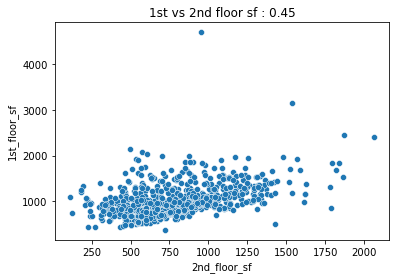

In [14]:
# check correlation of ground_living_sf and basement_total_sf

corr = df[df['2nd_floor_sf'] > 0][['2nd_floor_sf','1st_floor_sf']].corr()

sns.scatterplot(x='2nd_floor_sf',y='1st_floor_sf',data=df[df['2nd_floor_sf'] > 0])
plt.title(f"1st vs 2nd floor sf : {corr['2nd_floor_sf'][1].round(2)}");

# some correlation in 1st and 2nd floor

In [189]:
# Create has 2nd floor feature
df['has_2nd_floor_sf'] = df['2nd_floor_sf'].apply(lambda x : 0 if x == 0 else 1)

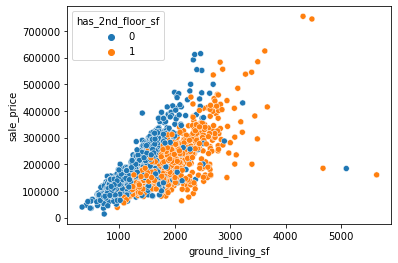

In [16]:
# plot scatter of sale_price and ground_living_area with hue `has_2nd_floor_sf`
plt.subplots_adjust(left=0.15)
sns.scatterplot(x='ground_living_sf',y='sale_price',data=df,hue='has_2nd_floor_sf');

plt.savefig('../figure/2nd_floor.png', format='png', dpi=720)

__Intepretation:__
- Square footage of 2nd floor correlates with 1st floor, slightly (0.45)
- For houses with similar square footage : 2 floors will be cheaper than 1 floor

__Takeaway:__
- 2nd floor sf correlates quite significantly with 1st floor sf
- We can only keep has_2nd_floor_sf
- keep ground_living_sf because it's a summation of 1st_floor_sf and 2nd_floor_sf

In [17]:
# assign columns to drop
cols_to_drop.extend(['1st_floor_sf','2nd_floor_sf'])

In [18]:
# mostly empty let's assign to cols_to_drop
df['low_quality_fin_sf'].value_counts().head(4)

0      2172
80        3
360       2
392       1
Name: low_quality_fin_sf, dtype: int64

In [19]:
# assign to columns to drop
cols_to_drop.extend(['low_quality_fin_sf'])

In [20]:
# check for redundant columns
pd.Series(df['total_basement_sf'] == \
          (df['basement_fin_sf_1']+df['basement_fin_sf_2']+df['basement_unf_sf'])).mean(0)

# 1.0 meaning the three columns are redundant

1.0

In [21]:
cols_to_drop.extend(['basement_fin_sf_1','basement_fin_sf_2','basement_unf_sf'])

In [190]:
# create total sf column from combining sf in basement and ground living area
df['total_sf'] = df['total_basement_sf'] + df['ground_living_sf']

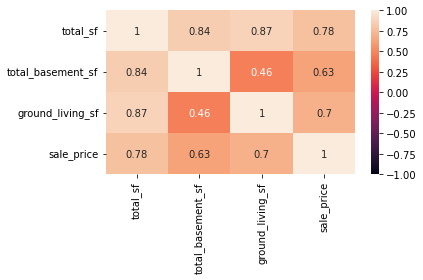

In [23]:
sns.heatmap(df[['total_sf','total_basement_sf','ground_living_sf','sale_price']].corr(),
            annot=True,
            vmin=-1,
            vmax=+1
           );
plt.tight_layout()
plt.savefig('../figure/combined_corr.png', format='png', dpi=720)

# seems to correlate better with sale_price

In [24]:
df[['total_sf','total_basement_sf','ground_living_sf','has_2nd_floor_sf','2nd_floor_sf','sale_price']].corr()
# seems to correlate better with sale_price

,total_sf,total_basement_sf,ground_living_sf,has_2nd_floor_sf,2nd_floor_sf,sale_price
total_sf,1.000000,0.837586,0.872977,0.109637,0.293765,0.778508
total_basement_sf,0.837586,1.000000,0.464726,-0.319920,-0.196807,0.629605
ground_living_sf,0.872977,0.464726,1.000000,0.463336,0.651852,0.699675
has_2nd_floor_sf,0.109637,-0.319920,0.463336,1.000000,0.906361,0.087597
2nd_floor_sf,0.293765,-0.196807,0.651852,0.906361,1.000000,0.264890
sale_price,0.778508,0.629605,0.699675,0.087597,0.264890,1.000000


In [25]:
# add columns to drop
cols_to_drop.extend(['total_basement_sf','ground_living_sf'])

In [191]:
# Create a boolean column of has_basement feature

df['has_basement_sf'] = df['total_basement_sf'].apply(lambda x : 1 if x > 0 else 0)

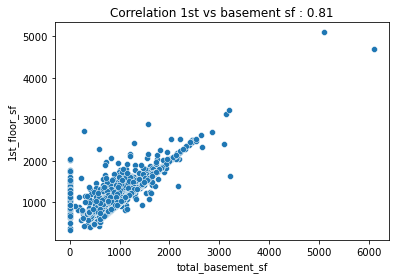

In [27]:
# check correlation of 1st_floor_sf and total_basement_sf

corr = df[['total_basement_sf','1st_floor_sf']].corr()

sns.scatterplot(x='total_basement_sf',y='1st_floor_sf',data=df)
plt.title(f"Correlation 1st vs basement sf : {corr['total_basement_sf'][1].round(2)}");

# Basement is usually the same size as 1st floor sf
# Keeping the two will create multi-collinearity, dropping is justified

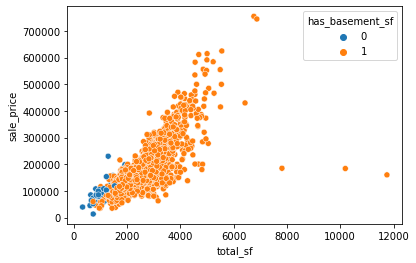

In [28]:
# plot scatter of sale_price and has_basement

sns.scatterplot(x='total_sf',y='sale_price',data=df,hue='has_basement_sf');

__Intepretation:__
- Total basement sf correlates highly with 1st floor sf
- Houses with the same ground_living_sf sells better if they have basement
- But majority of the houses actually has basement anyway

__Takeaway:__
- Could drop this because most houses has basement
- And basement_sf correlates to ground sf anyway, therefore we can probably drop this column
- Leave only the version of 'has_basement'

#### Bathroom Group

In [29]:
lot_cols = df.columns[df.columns.str.contains('bath')]
df[lot_cols].head(5)

,basement_full_bath,basement_half_bath,full_bath,half_bath
0,0.0,0.0,1,1
1,0.0,0.0,2,0
2,0.0,1.0,1,0
3,0.0,0.0,2,0
4,0.0,0.0,2,1


In [30]:
df['basement_full_bath'].value_counts()

0.0    1294
1.0     873
2.0      28
3.0       2
Name: basement_full_bath, dtype: int64

In [31]:
df['basement_half_bath'].value_counts()

0.0    2061
1.0     133
2.0       3
Name: basement_half_bath, dtype: int64

In [32]:
df['full_bath'].value_counts()

2    1187
1     945
3      56
0       6
4       3
Name: full_bath, dtype: int64

In [33]:
df['half_bath'].value_counts()

0    1404
1     774
2      19
Name: half_bath, dtype: int64

In [192]:
# Create combined column
df['total_bath'] = df['full_bath'] + df['half_bath']*0.5 + df['basement_full_bath'] + df['basement_half_bath']*0.5

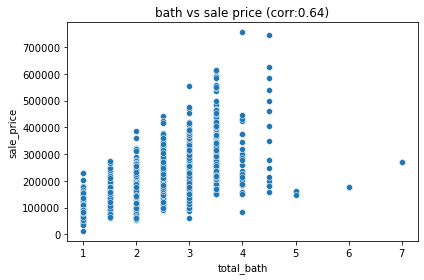

In [35]:
# Some correlation
corr = df[['total_bath','sale_price']].corr().round(2)

plt.title(f"bath vs sale price (corr:{corr['total_bath'][1]})")
sns.scatterplot(x='total_bath',y='sale_price',data=df)

plt.tight_layout()
plt.savefig('../figure/bath.png', format='png', dpi=720);

In [36]:
# add redundant columns to drop
cols_to_drop.extend(['full_bath','half_bath','basement_full_bath','basement_half_bath'])

__Interpretation:__
- Combining all baths shows higher correlation with sale price

#### Above Ground Group

In [37]:
lot_cols = df.columns[df.columns.str.contains('above')]
df[lot_cols].head(5)

,bedroom_above_ground,kitchen_above_ground,total_rooms_above_ground
0,3,1,6
1,3,1,7
2,3,1,7
3,2,1,6
4,3,1,7


In [38]:
df[['bedroom_above_ground','sale_price']].corr()

,bedroom_above_ground,sale_price
bedroom_above_ground,1.000000,0.144923
sale_price,0.144923,1.000000


In [39]:
df[['total_rooms_above_ground','sale_price']].corr()

,total_rooms_above_ground,sale_price
total_rooms_above_ground,1.000000,0.486375
sale_price,0.486375,1.000000


In [40]:
df[['kitchen_above_ground','sale_price']].corr()

,kitchen_above_ground,sale_price
kitchen_above_ground,1.000000,-0.129349
sale_price,-0.129349,1.000000


In [41]:
# check for redundant columns
pd.Series(df['total_rooms_above_ground'] == \
          (df['kitchen_above_ground']+df['bedroom_above_ground'])).mean(0)

# They don't add up, let's keep all three for now

0.007282658170232135

#### Porch group

In [42]:
porch_cols = df.columns[df.columns.str.contains('porch')]
df[lot_cols].head(5)

,bedroom_above_ground,kitchen_above_ground,total_rooms_above_ground
0,3,1,6
1,3,1,7
2,3,1,7
3,2,1,6
4,3,1,7


In [43]:
porch_cols

Index(['open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch'], dtype='object')

In [44]:
pd.Series(df['open_porch_sf']>0).mean()

0.567592171142467

In [45]:
pd.Series(df['enclosed_porch']>0).mean()

0.15430131998179336

In [46]:
pd.Series(df['3ssn_porch']>0).mean()

0.012289485662266727

In [47]:
pd.Series(df['screen_porch']>0).mean()

0.08557123350022758

In [193]:
# Create a summation column
df['porch_sf'] = df['open_porch_sf']+df['enclosed_porch']+df['3ssn_porch']+df['screen_porch']

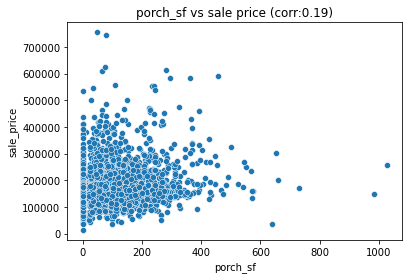

In [49]:
# Sale price doesn't really correlate well with porch sf
corr = df[['porch_sf','sale_price']].corr().round(2)

plt.title(f"porch_sf vs sale price (corr:{corr['porch_sf'][1]})")
sns.scatterplot(x='porch_sf',y='sale_price',data=df);

In [194]:
# Create a boolean column of has porch
df['has_porch'] = df['porch_sf'].apply(lambda x : 1 if x > 0 else 0)

In [51]:
df[['has_porch','sale_price']].corr()

,has_porch,sale_price
has_porch,1.000000,0.298882
sale_price,0.298882,1.000000


In [52]:
df['has_porch'].value_counts(normalize=True)

1    0.706418
0    0.293582
Name: has_porch, dtype: float64

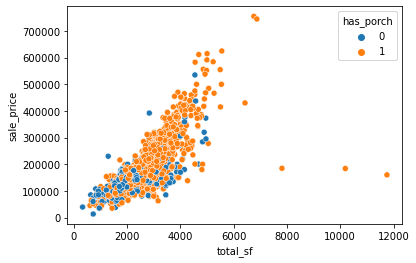

In [53]:
# plot scatter of sale_price and has_porch

sns.scatterplot(x='total_sf',y='sale_price',data=df,hue='has_porch');

In [195]:
df['has_open_porch'] = df['open_porch_sf'].apply(lambda x : 1 if x > 0 else 0)

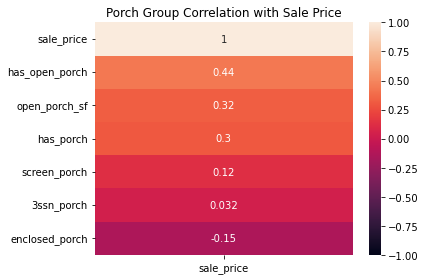

In [55]:
sns.heatmap(df[['open_porch_sf','enclosed_porch','3ssn_porch','screen_porch','has_porch','has_open_porch','sale_price']].corr()\
            [['sale_price']].sort_values(by='sale_price',ascending=False),
            annot=True,
            vmin=-1,
            vmax=1
           );
plt.title("Porch Group Correlation with Sale Price")
plt.tight_layout()
plt.savefig('../figure/porch_cor.png', format='png', dpi=720)
# has open porch is a better indicator of sale price

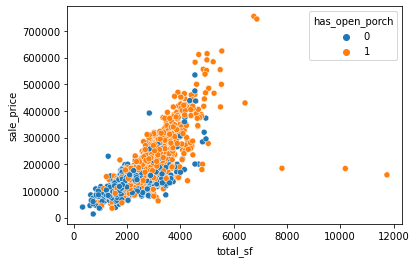

In [56]:
# plot scatter of sale_price and has_porch

sns.scatterplot(x='total_sf',y='sale_price',data=df,hue='has_open_porch');

__Interpretation:__
- above 70% of houses `has_porch`
- But from the mix, we can see that it doesn't really influence the `sale_price`
- `has_open_porch` is actually the one that correlates most with the prices
- let's keep only `has_open_porch`

In [57]:
cols_to_drop.extend(['open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch',
       'porch_sf', 'has_porch'])

#### Year group

In [196]:
df['built-remodel'] = df['year_remodel']-df['year_built']

In [59]:
df['built-remodel'].value_counts(normalize=True)

0      0.535275
1      0.156122
30     0.010924
40     0.010469
25     0.009558
         ...   
105    0.000455
121    0.000455
66     0.000455
59     0.000455
122    0.000455
Name: built-remodel, Length: 115, dtype: float64

In [60]:
df[['year_built','year_remodel','year_sold','sale_price']].corr()['sale_price']

year_built      0.559975
year_remodel    0.531341
year_sold      -0.024833
sale_price      1.000000
Name: sale_price, dtype: float64

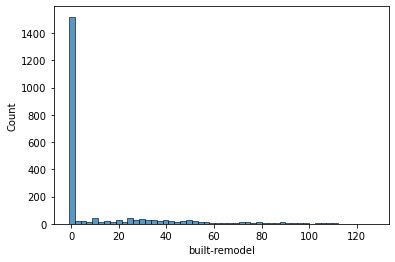

In [61]:
sns.histplot(x='built-remodel',data=df);

__Interpretation:__
- 50% of houses has no `year_remodel` i.e. same year as `year_built`
- It would be a duplicate of columns so we will only keep `year_built` as it has higher correlation
- keep `year_sold` for now since it doesn't correlate with other columns

In [62]:
cols_to_drop.extend(['year_remodel','built-remodel'])

#### Investigate fireplace

In [63]:
fireplace_cols = df.columns[df.columns.str.contains('fireplace')]
df[fireplace_cols].head(5)

,fireplace,fireplace_quality
0,0,None
1,1,TA
2,1,Gd
3,1,Gd
4,0,None


In [197]:
# create has fireplace 
df['has_fireplace'] = df['fireplace'].apply(lambda x:1 if x > 0 else 0)

In [65]:
df[['fireplace','has_fireplace','sale_price']].corr()

,fireplace,has_fireplace,sale_price
fireplace,1.000000,0.897820,0.485029
has_fireplace,0.897820,1.000000,0.487979
sale_price,0.485029,0.487979,1.000000


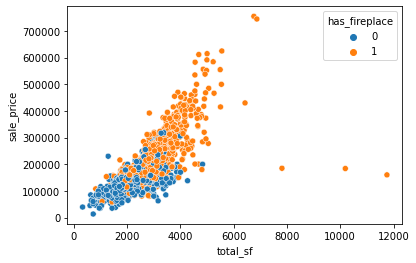

In [66]:
# plot scatter of sale_price and has_basement

sns.scatterplot(x='total_sf',y='sale_price',data=df,hue='has_fireplace');

__Interpretation__
- Seem like houses with similar square footage will sell more expensively if they have fireplace
- And from correlation, we can see that the no. of fireplace doesn't really matter
- What matters is whether the house has fireplace or not

__Key Takeaway:__
- We can convert `fireplace` column to `has_fireplace`

In [67]:
cols_to_drop.extend(['fireplace'])

#### Garage Group

In [68]:
garage_cols = df.columns[df.columns.str.contains('garage')]
df[garage_cols].head(5)

,garage_type,garage_year_built,garage_fin,garage_cars,garage_area,garage_quality,garage_condition
0,Detchd,2007.0,RFn,2.0,576.0,TA,TA
1,Attchd,1990.0,RFn,3.0,701.0,TA,TA
2,Basment,1958.0,RFn,2.0,525.0,TA,TA
3,Attchd,2008.0,RFn,2.0,539.0,TA,TA
4,BuiltIn,2004.0,Fin,2.0,400.0,TA,TA


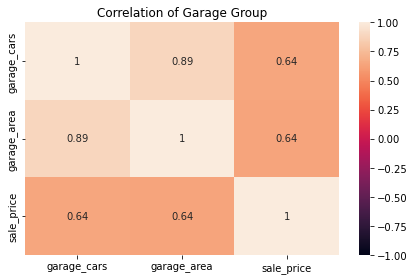

In [69]:
sns.heatmap(df[['garage_cars', 'garage_area','sale_price']].corr(),
            annot=True,
            vmin=-1,
            vmax=1)
plt.title('Correlation of Garage Group')
plt.tight_layout()
plt.savefig('../figure/garage.png', format='png', dpi=720);

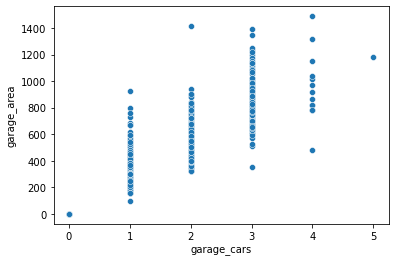

In [70]:
sns.scatterplot(x='garage_cars',y='garage_area',data=df);

__Interpretation:__
- Garage cars actually correlates to garage area
- We can only keep one of them
- Since `garage_cars` is sligthly more correlated with `sale_price` we will keep `garage_cars`

In [71]:
cols_to_drop.extend(['garage_area'])

In [72]:
# How many garages are built on the same year as house
(df['garage_year_built'] == df['year_built']).mean()

0.8215748748293127

In [73]:
# We can actually drop this since they're highly correlated
cols_to_drop.extend(['garage_year_built'])

#### Wood Deck

In [74]:
wood_cols = df.columns[df.columns.str.contains('wood')]
df[wood_cols].head(5)

,wood_deck_sf
0,0
1,84
2,0
3,192
4,0


In [198]:
# Create boolean feature column
df['has_wood_deck'] = df['wood_deck_sf'].apply(lambda x : 1 if x > 0 else 0)

In [76]:
df[['wood_deck_sf','has_wood_deck','sale_price']].corr()

,wood_deck_sf,has_wood_deck,sale_price
wood_deck_sf,1.000000,0.790066,0.343644
has_wood_deck,0.790066,1.000000,0.324547
sale_price,0.343644,0.324547,1.000000


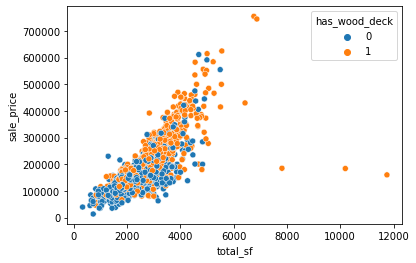

In [77]:
# plot scatter of sale_price and has_basement

sns.scatterplot(x='total_sf',y='sale_price',data=df,hue='has_wood_deck');

__Interpretation__
- Seem like houses with similar square footage will sell more expensively if they have wood deck
- Although it's not as clear as other features e.g. fireplace
- We can see that `has_wood_deck` houses has higher `sale_price` in general
- `has_wood_deck` also correlates better with sale price

__Key Takeaway:__
- keep `has_wood_deck` drop `wood_deck_sf`

In [78]:
cols_to_drop.extend(['wood_deck_sf'])

#### Masonry

In [199]:
df['has_masonry'] = df['masonry_area'].apply(lambda x : 1 if x > 0 else 0)

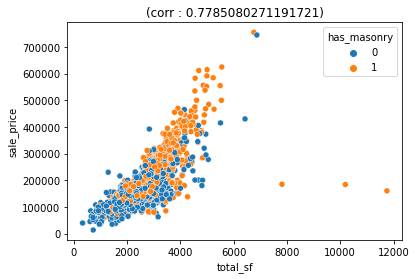

In [80]:
# plot scatter of sale_price and has_basement
feature = 'total_sf'
cor = df[[feature,'sale_price']].corr()
plt.title(f"(corr : {cor['sale_price'][0]})")
sns.scatterplot(x=feature,y='sale_price',data=df, hue='has_masonry');

In [81]:
df[['masonry_area','has_masonry','sale_price']].corr()

,masonry_area,has_masonry,sale_price
masonry_area,1.000000,0.696212,0.506901
has_masonry,0.696212,1.000000,0.395579
sale_price,0.506901,0.395579,1.000000


In [82]:
#cols_to_drop.extend(['masonry_area'])
cols_to_drop.extend(['has_masonry'])

#### Pool

In [83]:
df['pool_area'].value_counts()

0      2185
738       1
576       1
555       1
480       1
512       1
648       1
368       1
519       1
144       1
800       1
561       1
228       1
Name: pool_area, dtype: int64

In [84]:
cols_to_drop.extend(['pool_area'])

#### Misc

In [85]:
df['misc_value'].value_counts().head(5)

0       2119
400       12
500       11
450        6
2000       6
Name: misc_value, dtype: int64

In [86]:
cols_to_drop.extend(['misc_value'])

#### MS subclass

In [87]:
cols_to_drop.extend(['ms_subclass'])

#### Converting month to string

In [200]:
# Convert month_sold to string
df['month_sold'] = df['month_sold'].apply(lambda x : str(x))

#### Execute column grouping

In [89]:
# create column groups to classify action
print(cols_to_drop)

['Order', 'pid', '1st_floor_sf', '2nd_floor_sf', 'low_quality_fin_sf', 'basement_fin_sf_1', 'basement_fin_sf_2', 'basement_unf_sf', 'total_basement_sf', 'ground_living_sf', 'full_bath', 'half_bath', 'basement_full_bath', 'basement_half_bath', 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch', 'porch_sf', 'has_porch', 'year_remodel', 'built-remodel', 'fireplace', 'garage_area', 'garage_year_built', 'wood_deck_sf', 'has_masonry', 'pool_area', 'misc_value', 'ms_subclass']


In [201]:
for col in cols_to_drop:
    df.drop(columns=[col],inplace=True)

### Check resulting numerical columns

In [91]:
df.select_dtypes(exclude=object).head(5)

,lot_frontage,lot_area,overall_quality,overall_condition,year_built,masonry_area,bedroom_above_ground,kitchen_above_ground,total_rooms_above_ground,garage_cars,year_sold,sale_price,has_2nd_floor_sf,total_sf,has_basement_sf,total_bath,has_open_porch,has_fireplace,has_wood_deck
0,80.0,9605,7,6,2007,0.0,3,1,6,2.0,2009,159000,0,2436.0,1,1.5,1,0,0
1,90.0,14684,7,7,1990,234.0,3,1,7,3.0,2009,271900,0,4354.0,1,2.0,1,1,1
2,60.0,14375,6,6,1958,541.0,3,1,7,2.0,2009,137500,0,2163.0,1,1.5,1,1,0
3,48.0,6472,9,5,2008,500.0,2,1,6,2.0,2009,248500,0,2907.0,1,2.0,1,1,1
4,61.0,9734,7,5,2004,0.0,3,1,7,2.0,2009,167000,1,1758.0,1,2.5,0,0,0


In [92]:
# check remaining columns
df.select_dtypes(exclude=object).columns

Index(['lot_frontage', 'lot_area', 'overall_quality', 'overall_condition',
       'year_built', 'masonry_area', 'bedroom_above_ground',
       'kitchen_above_ground', 'total_rooms_above_ground', 'garage_cars',
       'year_sold', 'sale_price', 'has_2nd_floor_sf', 'total_sf',
       'has_basement_sf', 'total_bath', 'has_open_porch', 'has_fireplace',
       'has_wood_deck'],
      dtype='object')

## Clean Categorical Columns

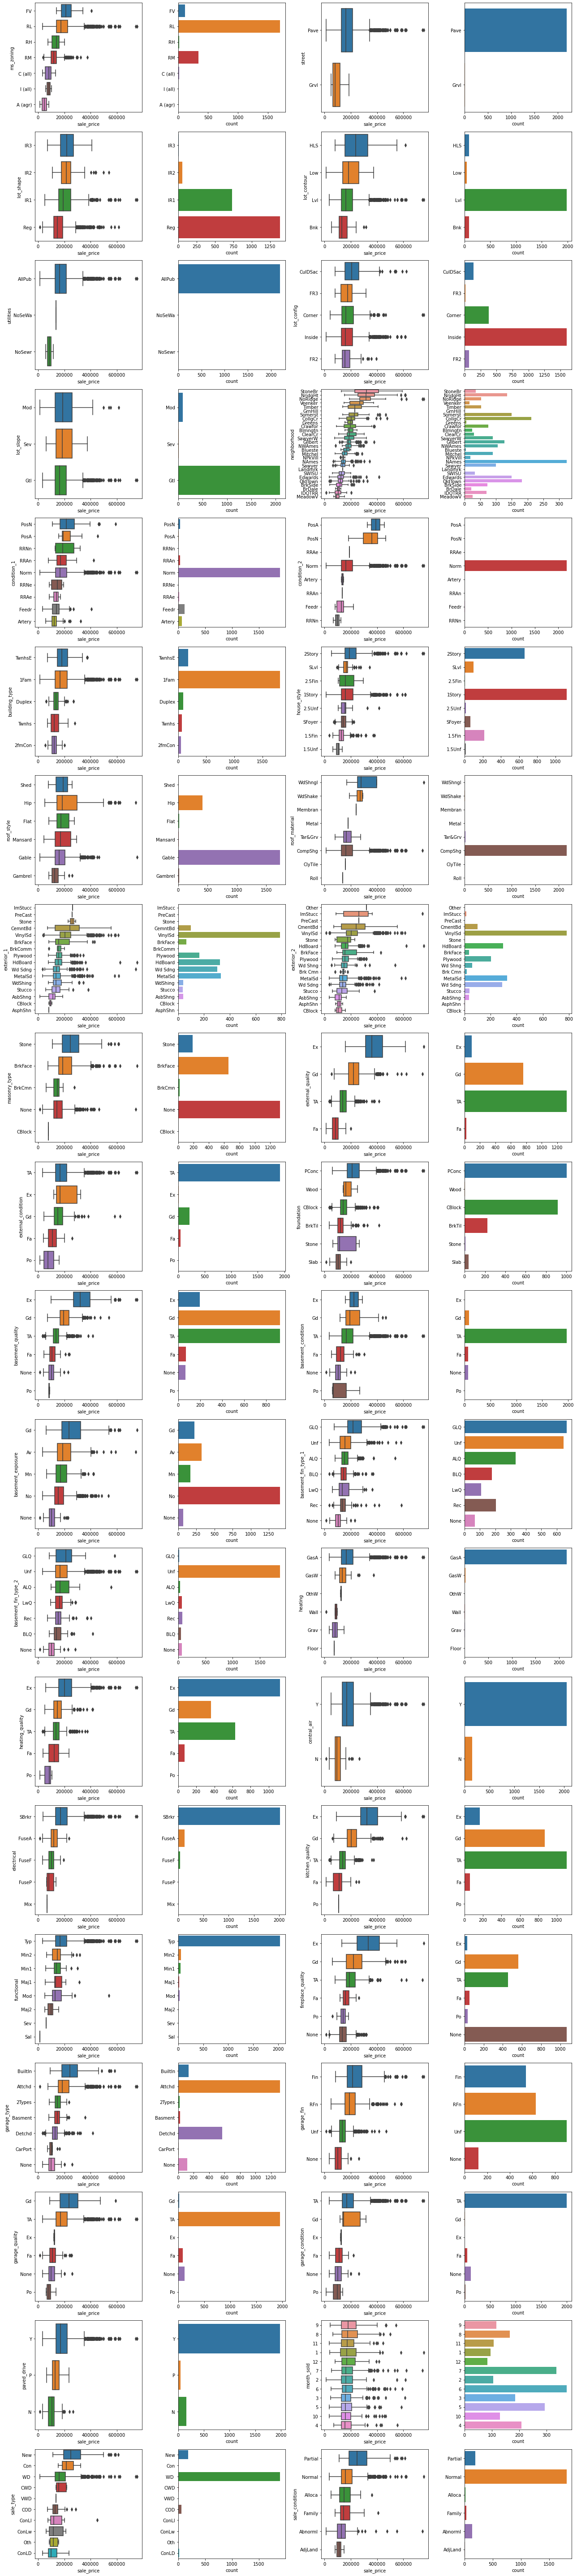

In [93]:
fig, axes = plt.subplots(20, 4, figsize=(18,80)) ## 20 rows * 4 columns

for i, feat in enumerate(list(df.select_dtypes(include=object).columns)): ## iterate column name
    x = i // 2  ## row index
    y = 2*i % 4  ## column index
    plot1 = sns.boxplot(
        ax=axes[x,y],
        y=feat,
        x='sale_price',
        orient='h',
        order=df.groupby(feat)['sale_price'].median().sort_values(ascending=False).index,
        data=df)
    plot2 = sns.countplot(
        ax=axes[x,y+1],
        y=feat,
        order=df.groupby(feat)['sale_price'].median().sort_values(ascending=False).index, ## only top10
        data=df)
    plot2.set(ylabel=None) ## show ylabel only boxplot 
    
plt.tight_layout()

## Execution of categorical grouping

Grouping Dictionaries

In [94]:
def map_building_type(string):
    build_dict = {'1Fam':'1F','2fmCon':'2F','Duplex':'D','TwnhsE':'T','Twnhs':'T'}
    return build_dict[string]

In [95]:
def map_house_style(string):
    house_dict = {'1Story':'1','1.5Fin':'1','1.5Unf':'1','2.5Fin':'2','2.5Unf':'2','2Story':'2',\
                  'SLvl':'S','SFoyer':'S'}
    return house_dict[string]

In [96]:
def garage_type_map(string):
    garage_dict = {'Detchd':'D','Attchd':'A','BuiltIn':'B','Basment':'O','2Types':'O','None':'O','CarPort':'O'}
    return garage_dict[string]

In [97]:
def garage_q_map(string):
    garage_q_dict = {'TA':'A','Gd':'G','Fa':'O','None':'O','Po':'O','Ex':'O'}
    return garage_q_dict[string]

In [98]:
def map_condition_1(string):
    condition_dict = {'Norm':'N','Feedr':'F','Artery':'A','RRAn':'R','RRNe':'R','RRAe':'R',\
                      'RRNn':'R','PosA':'P','PosN':'P'}
    return condition_dict[string]

In [99]:
def sale_type_map(string):
    condition_dict = {'WD ':'W','VWD':'W','CWD':'W','New':'N','COD':'COD','ConLD':'CON','ConLw':'CON',
                     'Con':'CON','ConLI':'CON','Oth':'CON'}
    return condition_dict[string]

In [100]:
def sale_cond_map(string):
    condition_dict = {'Normal':'N','Partial':'P','Abnorml':'Other','Family':'Other','Alloca':'Other'
                      ,'AdjLand':'Other'}
    return condition_dict[string]

In [101]:
def mason_type_map(string):
    mason_dict = {'None':'N','BrkFace':'B','BrkCmn':'B','CBlock':'B','Stone':'S'}
    return mason_dict[string]

In [102]:
def roof_style_map(string):
    roof_dict = {'Gable':'G','Hip':'H','Flat':'O','Gambrel':'O','Shed':'O','Mansard':'O'}
    return roof_dict[string]

In [103]:
def basement_quality_map(string):
    base_dict = {'TA':'A','Gd':'G','Fa':'O','None':'O','Po':'O','Ex':'E'}
    return base_dict[string]

Grouping Execution

In [202]:
# Group residential and none
df['ms_zoning'] = df['ms_zoning'].apply(lambda x : 'Res' if x in ['RL','RM','FV','RH','RP'] else 'Non')

In [203]:
# Convert street to boolean
df['street'] = df['street'].apply(lambda x : 1 if x == 'Pave' else 0)

In [204]:
# Convert lotshape to boolean - Reg = 1 , Else = 0
df['lot_shape'] = df['lot_shape'].apply(lambda x : 1 if x == 'Reg' else 0)

In [205]:
# Convert lot_contour to boolean - Level = 1 , Else = 0
df['lot_contour'] = df['lot_contour'].apply(lambda x : 1 if x == 'Lvl' else 0)

In [206]:
# Convert lot_slope to boolean - Gtl =1 , Else = 0
df['lot_slope'] = df['lot_slope'].apply(lambda x : 1 if x == 'Gtl' else 0)

In [207]:
# Group up heating quality
df['heating_quality'] = df['heating_quality'].apply(lambda x : 'Fa' if x == 'Po' else x)

In [208]:
# Convert central air to boolean - Y = 1 (has central air)
df['central_air'] = df['central_air'].apply(lambda x : 1 if x == 'Y' else 0)

In [209]:
# Combine Unf and Na
df['garage_fin'] = df['garage_fin'].apply(lambda x : 'Unf' if (x=='NA') else x)

In [210]:
# Group up condition 1 from dictionary mapping
df['condition_1'] = df['condition_1'].apply(map_condition_1)

In [211]:
# Group up sale tyupe from dictionary mapping
df['sale_type'] = df['sale_type'].apply(sale_type_map)

In [212]:
# Group up garage type from dictionary mapping
df['garage_type'] = df['garage_type'].apply(garage_type_map)

In [213]:
# Group up garage quality from dictionary mapping
df['garage_quality'] = df['garage_quality'].apply(garage_q_map)

In [214]:
# Group up building type from dictionary mapping
df['building_type'] = df['building_type'].apply(map_building_type)

In [215]:
# Group up house style from dictionary mapping
df['house_style'] = df['house_style'].apply(map_house_style)

In [216]:
# Group up kitchen quality to Ta except Good and Excellent
df['kitchen_quality'] = df['kitchen_quality'].apply(lambda x : x if (x=='Gd') or (x=='Ex') else 'Ta')

In [217]:
# Convert functional to boolean
df['functional'] = df['functional'].apply(lambda x : 1 if x == 'Typ' else 0)

In [218]:
# Group up sale condition from dictionary mapping
df['sale_condition'] = df['sale_condition'].apply(sale_cond_map)

In [219]:
# Group up roofstyle from dictionary mapping
df['roof_style'] = df['roof_style'].apply(roof_style_map)

In [220]:
# Group up masonry from dictionary mapping
df['masonry_type'] = df['masonry_type'].apply(mason_type_map)

In [221]:
# Group up masonry from dictionary mapping
df['basement_quality'] = df['basement_quality'].apply(basement_quality_map)

Check outcome

In [124]:
df.select_dtypes(include=object).columns

Index(['ms_zoning', 'utilities', 'lot_config', 'neighborhood', 'condition_1',
       'condition_2', 'building_type', 'house_style', 'roof_style',
       'roof_material', 'exterior_1', 'exterior_2', 'masonry_type',
       'external_quality', 'external_condition', 'foundation',
       'basement_quality', 'basement_condition', 'basement_exposure',
       'basement_fin_type_1', 'basement_fin_type_2', 'heating',
       'heating_quality', 'electrical', 'kitchen_quality', 'fireplace_quality',
       'garage_type', 'garage_fin', 'garage_quality', 'garage_condition',
       'paved_drive', 'month_sold', 'sale_type', 'sale_condition'],
      dtype='object')

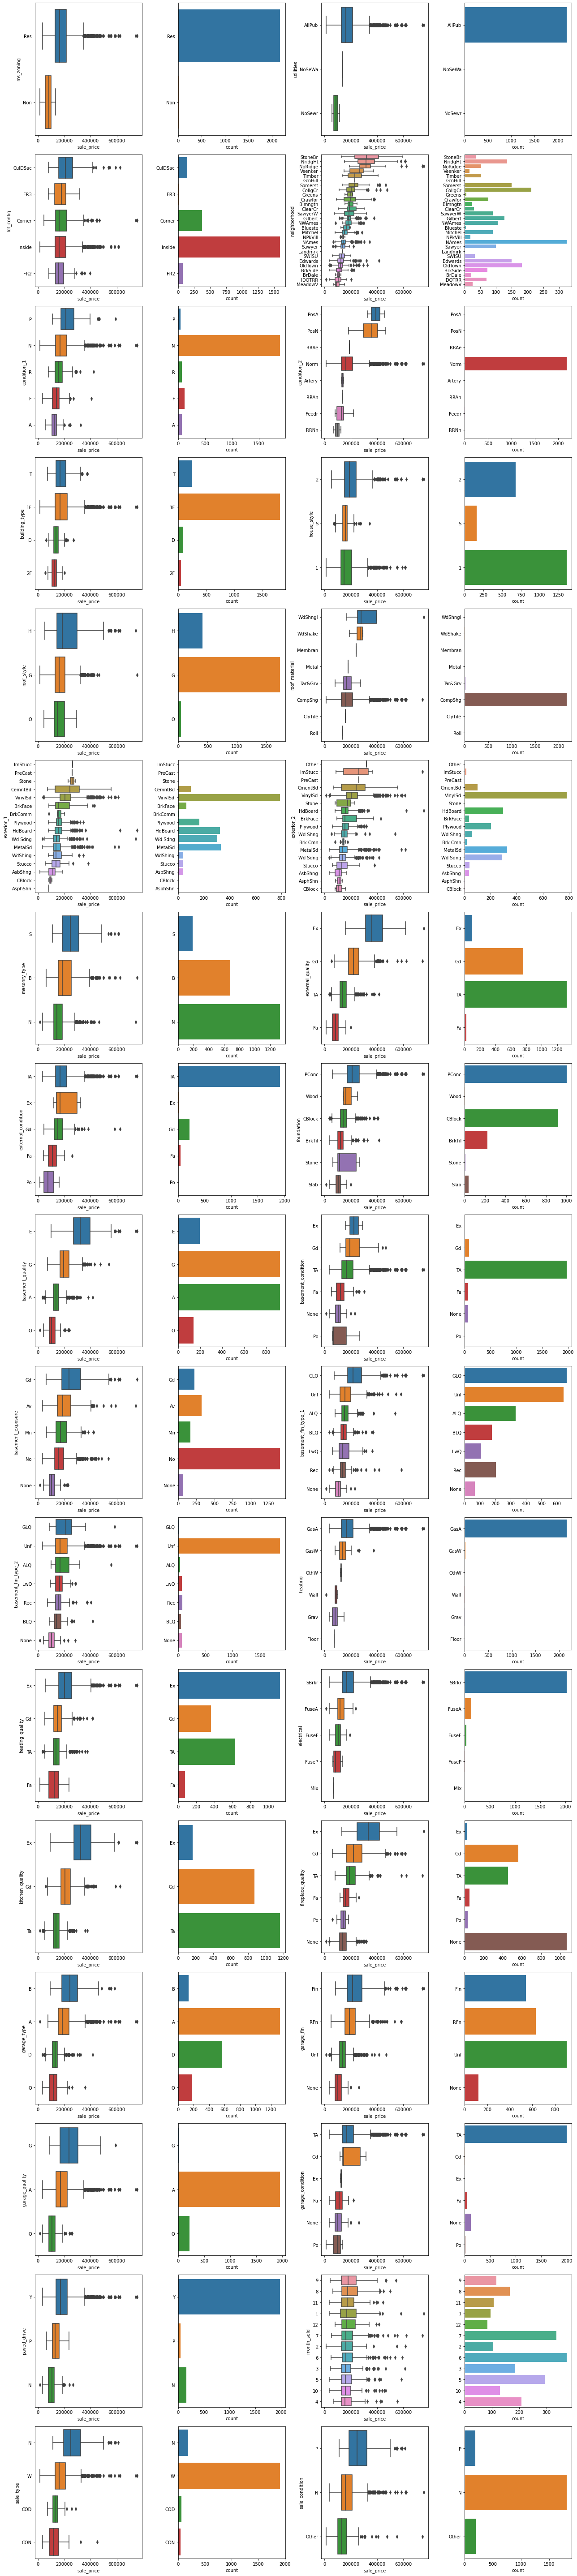

In [125]:
fig, axes = plt.subplots(17, 4, figsize=(18,80)) ## 16 rows * 4 columns

for i, feat in enumerate(list(df.select_dtypes(include=object).columns)): ## iterate column name
    x = i // 2  ## row index
    y = 2*i % 4  ## column index
    plot1 = sns.boxplot(
        ax=axes[x,y],
        y=feat,
        x='sale_price',
        orient='h',
        order=df.groupby(feat)['sale_price'].median().sort_values(ascending=False).index,
        data=df)
    plot2 = sns.countplot(
        ax=axes[x,y+1],
        y=feat,
        order=df.groupby(feat)['sale_price'].median().sort_values(ascending=False).index, ## only top10
        data=df)
    plot2.set(ylabel=None) ## show ylabel only boxplot 
    
plt.tight_layout()

## Feature Engineering

In [126]:
# Create log_sale_price column
df['log_sale_price'] = df['sale_price'].apply(np.log)

In [222]:
# Log lot area correlates better with sale price
df['log_lot_area'] = df['lot_area'].apply(np.log)

In [128]:
# Log total sf
#df['log_total_sf'] = df['total_sf'].apply(np.log)

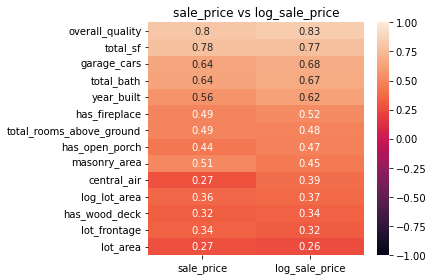

In [129]:
sns.heatmap(df.corr()[['sale_price','log_sale_price']].sort_values(by='log_sale_price',ascending=False)[2:16],
            annot=True,
            vmin=-1,
            vmax=1);
plt.title('sale_price vs log_sale_price')
plt.tight_layout()
plt.savefig('../figure/log_sale_corr.png', format='png', dpi=720);

### Clean Outliers

Loot Frontage

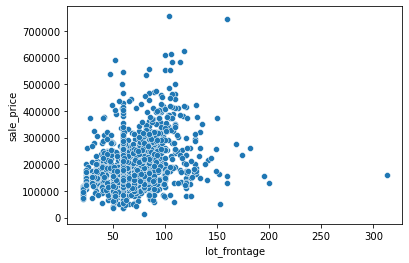

In [130]:
sns.scatterplot(x='lot_frontage',y='sale_price',data=df);

In [131]:
df[['lot_frontage']].sort_values('lot_frontage',ascending=False).head(3)

,lot_frontage
672,313.0
1882,200.0
1814,195.0


In [132]:
# Consider removing lot frontage outlier
df = df[df['lot_frontage']<195]

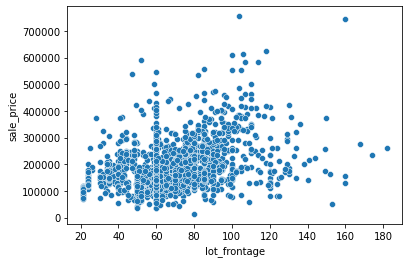

In [133]:
sns.scatterplot(x='lot_frontage',y='sale_price',data=df);

Lot Area

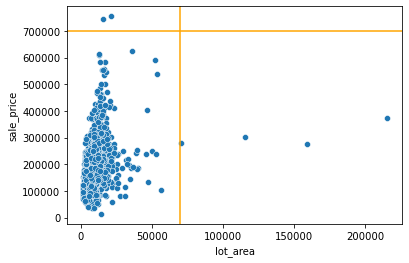

In [134]:
sns.scatterplot(x='lot_area',y='sale_price',data=df)
plt.axvline(x=70000,color='orange')
plt.axhline(y=700000,color='orange');

In [135]:
# Consider removing lot area outlier
df = df[df['lot_area'] < 70000]

In [136]:
# Remove sale price outlier
df = df[df['sale_price']<700000]

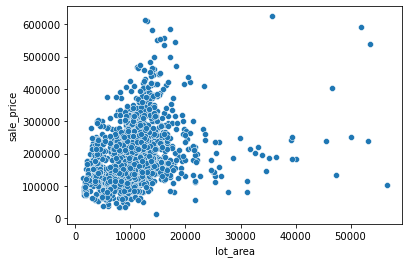

In [137]:
sns.scatterplot(x='lot_area',y='sale_price',data=df);

Log Lot Area

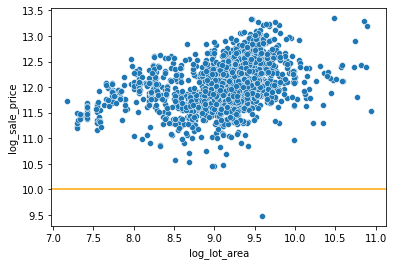

In [138]:
sns.scatterplot(x='log_lot_area',y='log_sale_price',data=df)
plt.axhline(y=10,color='orange');

In [139]:
df = df[df['log_sale_price'] > 10]

In [140]:
df[['log_lot_area','log_sale_price']].corr()

,log_lot_area,log_sale_price
log_lot_area,1.000000,0.372464
log_sale_price,0.372464,1.000000


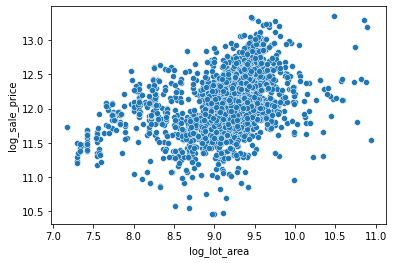

In [141]:
sns.scatterplot(x='log_lot_area',y='log_sale_price',data=df);

Total Square Footage

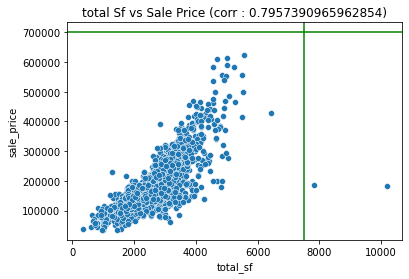

In [142]:
# plot scatter of sale_price and has_basement
plt.axvline(x=7500,color='green')
plt.axhline(y=700000,color='green')
cor = df[['total_sf','sale_price']].corr()
plt.title(f"total Sf vs Sale Price (corr : {cor['sale_price'][0]})")
sns.scatterplot(x='total_sf',y='sale_price',data=df);

In [143]:
df[['lot_area']].sort_values('lot_area',ascending=False).head(5)

,lot_area
332,56600
2141,53504
1590,53107
366,51974
215,50102


In [144]:
df[(df['total_sf']<3000) & (df['sale_price']>350000)]

,ms_zoning,lot_frontage,lot_area,street,lot_shape,lot_contour,utilities,lot_config,lot_slope,neighborhood,...,sale_price,has_2nd_floor_sf,total_sf,has_basement_sf,total_bath,has_open_porch,has_fireplace,has_wood_deck,log_sale_price,log_lot_area
2135,Res,60.0,8089,1,1,0,AllPub,Inside,1,StoneBr,...,392000,0,2838.0,1,3.0,0,1,1,12.879017,8.99826


In [145]:
# remove total_sf outlier
df = df[df['total_sf'] < 7500]

In [146]:
# remove outlier from small area but high price
df.drop(index=list(df[(df['total_sf']<2000) & (df['sale_price']>200000)].index),inplace=True)

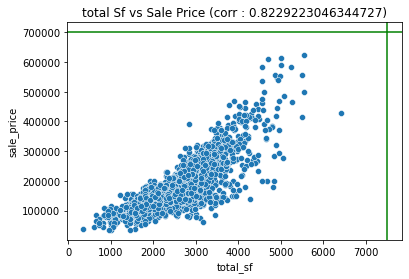

In [147]:
# plot scatter of sale_price and has_basement
plt.axvline(x=7500,color='green')
plt.axhline(y=700000,color='green')
cor = df[['total_sf','sale_price']].corr()
plt.title(f"total Sf vs Sale Price (corr : {cor['sale_price'][0]})")
sns.scatterplot(x='total_sf',y='sale_price',data=df);

Garage Cars

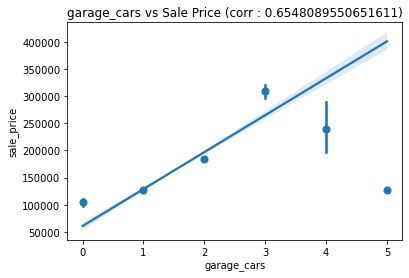

In [148]:
# plot scatter of sale_price and has_basement

cor = df[['garage_cars','sale_price']].corr()
plt.title(f"garage_cars vs Sale Price (corr : {cor['sale_price'][0]})")
sns.regplot(x='garage_cars',y='sale_price',data=df,x_estimator=np.mean);

In [149]:
# Remove outlier from garage cars
df = df[df['garage_cars']<4]

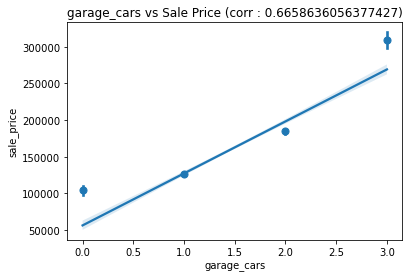

In [150]:
# plot scatter of sale_price and has_basement

cor = df[['garage_cars','sale_price']].corr()
plt.title(f"garage_cars vs Sale Price (corr : {cor['sale_price'][0]})")
sns.regplot(x='garage_cars',y='sale_price',data=df,x_estimator=np.mean);

Total Square footage vs log sale price

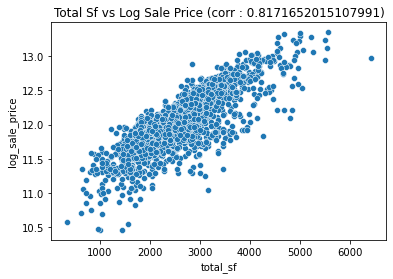

In [151]:
# plot scatter of sale_price and has_basement
cor = df[['total_sf','log_sale_price']].corr()
plt.title(f"Total Sf vs Log Sale Price (corr : {cor['log_sale_price'][0]})")
sns.scatterplot(x='total_sf',y='log_sale_price',data=df);

In [152]:
df = df[df['total_sf'] < 6000]
df = df[df['total_sf'] > 1000]

In [153]:
df = df[df['log_sale_price'] > 10.6]

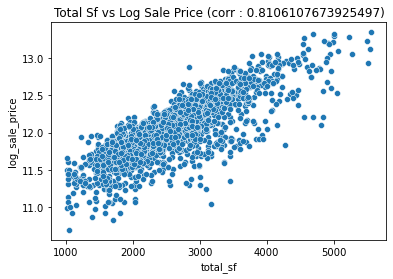

In [154]:
# plot scatter of sale_price and has_basement
cor = df[['total_sf','log_sale_price']].corr()
plt.title(f"Total Sf vs Log Sale Price (corr : {cor['log_sale_price'][0]})")
sns.scatterplot(x='total_sf',y='log_sale_price',data=df);

Oveall Quality

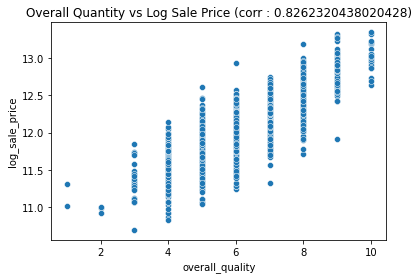

In [155]:
# plot scatter of sale_price and has_basement
cor = df[['overall_quality','log_sale_price']].corr()
plt.title(f"Overall Quantity vs Log Sale Price (corr : {cor['log_sale_price'][0]})")
sns.scatterplot(x='overall_quality',y='log_sale_price',data=df);

In [156]:
# remove overall quality 1 outliers
df = df[df['overall_quality'] > 1]

In [157]:
df[df['overall_quality'] > 2][['overall_quality','log_sale_price']].corr()

,overall_quality,log_sale_price
overall_quality,1.000000,0.823779
log_sale_price,0.823779,1.000000


In [158]:
# drop outlier in overall quality and log sale price
df.drop(index=list(df[(df['overall_quality']==9) & (df['log_sale_price']<12)].index),inplace=True)

In [159]:
# drop outlier in overall quality and log sale price
df.drop(index=list(df[(df['overall_quality']==6) & (df['log_sale_price']>12.5)].index),inplace=True)

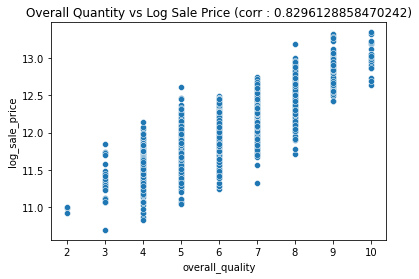

In [160]:
# plot scatter of sale_price and has_basement
cor = df[['overall_quality','log_sale_price']].corr()
plt.title(f"Overall Quantity vs Log Sale Price (corr : {cor['log_sale_price'][0]})")
sns.scatterplot(x='overall_quality',y='log_sale_price',data=df);

Total Rooms Above Ground

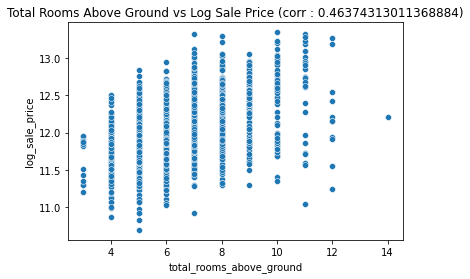

In [161]:
# plot scatter of sale_price and has_basement
cor = df[['total_rooms_above_ground','log_sale_price']].corr()
plt.title(f"Total Rooms Above Ground vs Log Sale Price (corr : {cor['log_sale_price'][0]})")
sns.scatterplot(x='total_rooms_above_ground',y='log_sale_price',data=df);

In [162]:
# remove total room outlier
df = df[df['total_rooms_above_ground']<12]

In [163]:
# remove total room outlier
df.drop(index=list(df[(df['total_rooms_above_ground']==11) & (df['log_sale_price']<12)].index),inplace=True)

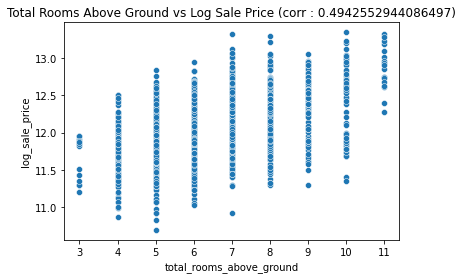

In [164]:
# plot scatter of sale_price and has_basement
cor = df[['total_rooms_above_ground','log_sale_price']].corr()
plt.title(f"Total Rooms Above Ground vs Log Sale Price (corr : {cor['log_sale_price'][0]})")
sns.scatterplot(x='total_rooms_above_ground',y='log_sale_price',data=df);

Total Bath

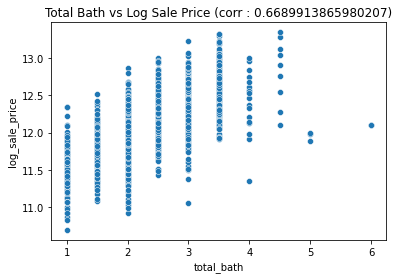

In [165]:
# plot scatter of sale_price and has_basement
cor = df[['total_bath','log_sale_price']].corr()
plt.title(f"Total Bath vs Log Sale Price (corr : {cor['log_sale_price'][0]})")
sns.scatterplot(x='total_bath',y='log_sale_price',data=df);

In [166]:
# remove all bath outliers
df = df[df['total_bath']<5]

In [167]:
# total bath = 3 outlier removed
df.drop(index=list(df[(df['total_bath']==3) & (df['log_sale_price']<11.25)].index),inplace=True)

In [168]:
# total bath = 4 outlier removed
df.drop(index=list(df[(df['total_bath']==4) & (df['log_sale_price']<11.5)].index),inplace=True)

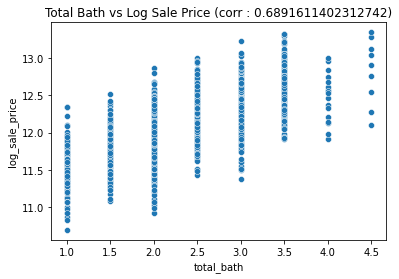

In [169]:
# plot scatter of sale_price and has_basement
cor = df[['total_bath','log_sale_price']].corr()
plt.title(f"Total Bath vs Log Sale Price (corr : {cor['log_sale_price'][0]})")
sns.scatterplot(x='total_bath',y='log_sale_price',data=df);

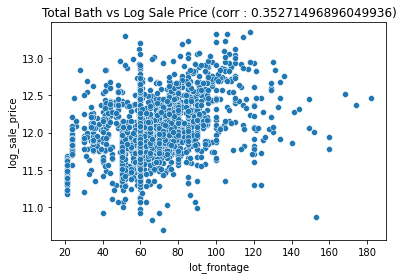

In [170]:
# plot scatter of sale_price and has_basement
cor = df[['lot_frontage','log_sale_price']].corr()
plt.title(f"Total Bath vs Log Sale Price (corr : {cor['log_sale_price'][0]})")
sns.scatterplot(x='lot_frontage',y='log_sale_price',data=df);

In [171]:
df.drop(index=list(df[(df['lot_frontage']>140) & (df['log_sale_price']<11)].index),inplace=True)

In [172]:
df = df[df['lot_frontage'] < 160]

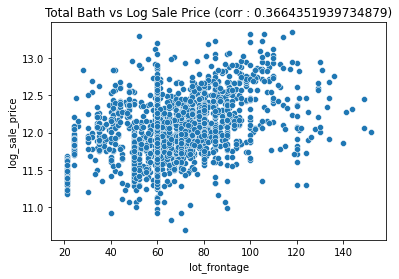

In [173]:
# plot scatter of sale_price and has_basement
cor = df[['lot_frontage','log_sale_price']].corr()
plt.title(f"Total Bath vs Log Sale Price (corr : {cor['log_sale_price'][0]})")
sns.scatterplot(x='lot_frontage',y='log_sale_price',data=df);

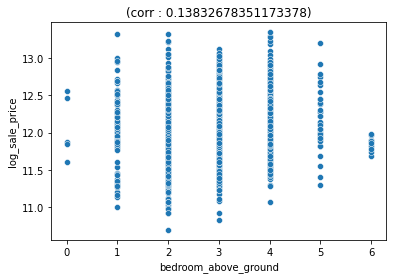

In [174]:
# plot scatter of sale_price and has_basement
feature = 'bedroom_above_ground'
cor = df[[feature,'log_sale_price']].corr()
plt.title(f"(corr : {cor['log_sale_price'][0]})")
sns.scatterplot(x=feature,y='log_sale_price',data=df);

In [175]:
df = df[df['bedroom_above_ground'] < 6]

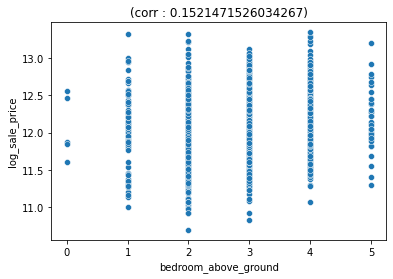

In [176]:
# plot scatter of sale_price and has_basement
feature = 'bedroom_above_ground'
cor = df[[feature,'log_sale_price']].corr()
plt.title(f"(corr : {cor['log_sale_price'][0]})")
sns.scatterplot(x=feature,y='log_sale_price',data=df);

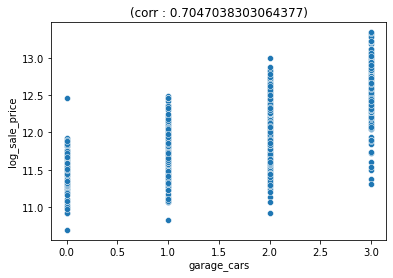

In [177]:
# plot scatter of sale_price and has_basement
feature = 'garage_cars'
cor = df[[feature,'log_sale_price']].corr()
plt.title(f"(corr : {cor['log_sale_price'][0]})")
sns.scatterplot(x=feature,y='log_sale_price',data=df);

In [178]:
df.drop(index=list(df[(df['garage_cars']==0)&(df['log_sale_price']>12)].index),inplace=True)

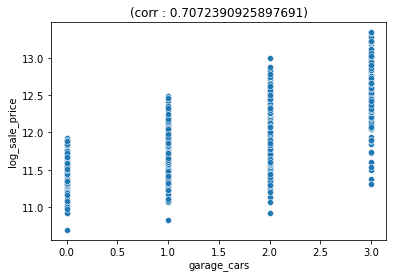

In [179]:
# plot scatter of sale_price and has_basement
feature = 'garage_cars'
cor = df[[feature,'log_sale_price']].corr()
plt.title(f"(corr : {cor['log_sale_price'][0]})")
sns.scatterplot(x=feature,y='log_sale_price',data=df);

In [180]:
df.corr()[['log_sale_price']].sort_values(by='log_sale_price',ascending=False)

,log_sale_price
log_sale_price,1.000000
sale_price,0.959698
overall_quality,0.833157
total_sf,0.830051
garage_cars,0.707239
total_bath,0.690591
year_built,0.637207
has_fireplace,0.511237
total_rooms_above_ground,0.510638
has_open_porch,0.481299


#### Remove lot_area

In [223]:
df.drop(columns=['lot_area'],inplace=True)

In [182]:
#df.drop(columns=['total_sf'],inplace=True)

In [183]:
df.columns

Index(['ms_zoning', 'lot_frontage', 'street', 'lot_shape', 'lot_contour',
       'utilities', 'lot_config', 'lot_slope', 'neighborhood', 'condition_1',
       'condition_2', 'building_type', 'house_style', 'overall_quality',
       'overall_condition', 'year_built', 'roof_style', 'roof_material',
       'exterior_1', 'exterior_2', 'masonry_type', 'masonry_area',
       'external_quality', 'external_condition', 'foundation',
       'basement_quality', 'basement_condition', 'basement_exposure',
       'basement_fin_type_1', 'basement_fin_type_2', 'heating',
       'heating_quality', 'central_air', 'electrical', 'bedroom_above_ground',
       'kitchen_above_ground', 'kitchen_quality', 'total_rooms_above_ground',
       'functional', 'fireplace_quality', 'garage_type', 'garage_fin',
       'garage_cars', 'garage_quality', 'garage_condition', 'paved_drive',
       'month_sold', 'year_sold', 'sale_type', 'sale_condition', 'sale_price',
       'has_2nd_floor_sf', 'total_sf', 'has_basement_sf'

In [224]:
df.shape

(733, 58)

In [225]:
len(df.select_dtypes(exclude=object).columns)

24

In [226]:
if status == 'train':
    df.to_csv('../datasets/train_cleaned.csv', index=False)
else:
    df.to_csv('../datasets/test_cleaned.csv', index=False)

----